In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_policy_arrows(q_table, grid_size=6):
    action_to_arrow = ['turn left  ', 'turn right ', 'go straight']
    policy = [["" for _ in range(grid_size)] for _ in range(grid_size)]

    for state, q_vals in q_table.items():
        state //= 3
        x = state % grid_size
        y = state // grid_size

        best_action = np.argmax(q_vals)
        policy[y][x] = action_to_arrow[best_action]
    
    policy[grid_size - 1][grid_size - 1] = 'Terminal'

    for row in policy:
        print(" ".join(row))

def plot_rewards(rewards_q, rewards_s, window=100):
    avg_q = np.convolve(rewards_q, np.ones(window)/window, mode='valid')
    avg_s = np.convolve(rewards_s, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(avg_q, label="Q-learning", color='blue')
    plt.plot(avg_s, label="SARSA", color='green')
    plt.xlabel("Episode")
    plt.ylabel(f"Moving Avg Reward ({window})")
    plt.title("Q-learning vs Sarsa")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def Summary_of_experimental_settings(num_iter, alpha):
    params = {
        'Agent': ['Q-learning', 'SARSA'],
        'Alpha (Learning rate)': [alpha, alpha],
        'Gamma (Discount factor)': [0.9, 0.9],
        'Epsilon (Exploration)': ['Decreased from 1.0 to 0.05', 'Decreased from 1.0 to 0.05'],
        'Environment': ['MiniGrid-Empty-6x6-v0', 'MiniGrid-Empty-6x6-v0'],
        'Episodes': [num_iter, num_iter]
    }

    df = pd.DataFrame(params)
    print("Experimental Settings")
    print(df.to_markdown(index=False))  # 깔끔한 콘솔 출력


In [3]:
alpha = 0.1
epsilon_init = 0.2
min_epsilon = 0.2
epsilon_descent = 1

class QLearning:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = alpha
        self.gamma = 0.9
        self.epsilon = epsilon_init
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        next_action = np.argmax(self.q_values[next_state])
        
        q_value = self.q_values[state][action]
        
        next_q_value = self.q_values[next_state][next_action]
        
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        if np.mean(list(self.q_values.values())) > 0:
            self.epsilon = max(min_epsilon, self.epsilon * epsilon_descent)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randint(0, self.actions - 1)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)

        return action

class Sarsa:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = alpha
        self.gamma = 0.9
        self.epsilon = epsilon_init
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        next_q_value = self.q_values[next_state][next_action]
        
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        if np.mean(list(self.q_values.values())) > 0:
            self.epsilon = max(min_epsilon, self.epsilon * epsilon_descent)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = random.randint(0, self.actions - 1)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)

        return action

In [4]:
from utils import gen_wrapped_env, show_video

In [5]:
env_q = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
env_s = gen_wrapped_env('MiniGrid-Empty-6x6-v0')

# env = gen_wrapped_env('MiniGrid-DoorKey-5x5-v0')

obs_q = env_q.reset()
obs_s = env_s.reset()

agent_q_position = obs_q[0]
agent_s_position = obs_s[0]

agent_q = QLearning(3, agent_q_position)
agent_s = Sarsa(3, agent_s_position)

In [6]:
rewards_q = []
rewards_s = []
num_iter = 20000

for ep in range(num_iter):
    done_q = False
    obs_q = env_q.reset()
    action_q = agent_q.act(obs_q)

    done_s = False
    obs_s = env_s.reset()
    action_s = agent_s.act(obs_s)
    
    ep_rewards_q = 0
    ep_rewards_s = 0

    while not done_q or not done_s:
        if not done_q:
            next_obs_q, reward_q, done_q, _ = env_q.step(action_q)

            agent_q.update(obs_q, action_q, reward_q, next_obs_q)
            
            next_action_q = agent_q.act(next_obs_q)
            
            ep_rewards_q += reward_q
            obs_q = next_obs_q
            action_q = next_action_q

        if not done_s:
            next_obs_s, reward_s, done_s, _ = env_s.step(action_s)

            next_action_s = agent_s.act(next_obs_s)

            agent_s.update(obs_s, action_s, reward_s, next_obs_s, next_action_s)
            
            ep_rewards_s += reward_s
            obs_s = next_obs_s
            action_s = next_action_s
    rewards_q.append(ep_rewards_q)
    rewards_s.append(ep_rewards_s)
    if (ep+1) % 100 == 0:
        avg_q = np.mean(rewards_q[-100:])
        avg_s = np.mean(rewards_s[-100:])
        print(f"[Episode {ep+1}] Q avg: {avg_q:.2f}, SARSA avg: {avg_s:.2f}")
env_q.close()
env_s.close()

[Episode 100] Q avg: 0.00, SARSA avg: 0.00
[Episode 200] Q avg: 0.00, SARSA avg: 0.00
[Episode 300] Q avg: 0.00, SARSA avg: 0.00
[Episode 400] Q avg: 0.00, SARSA avg: 0.00
[Episode 500] Q avg: 0.00, SARSA avg: 0.00
[Episode 600] Q avg: 0.00, SARSA avg: 0.00
[Episode 700] Q avg: 0.07, SARSA avg: 0.00
[Episode 800] Q avg: 0.33, SARSA avg: 0.15
[Episode 900] Q avg: 0.29, SARSA avg: 0.29
[Episode 1000] Q avg: 0.30, SARSA avg: 0.31
[Episode 1100] Q avg: 0.33, SARSA avg: 0.34
[Episode 1200] Q avg: 0.29, SARSA avg: 0.37
[Episode 1300] Q avg: 0.34, SARSA avg: 0.27
[Episode 1400] Q avg: 0.33, SARSA avg: 0.24
[Episode 1500] Q avg: 0.34, SARSA avg: 0.26
[Episode 1600] Q avg: 0.33, SARSA avg: 0.37
[Episode 1700] Q avg: 0.32, SARSA avg: 0.31
[Episode 1800] Q avg: 0.36, SARSA avg: 0.34
[Episode 1900] Q avg: 0.40, SARSA avg: 0.22
[Episode 2000] Q avg: 0.33, SARSA avg: 0.31
[Episode 2100] Q avg: 0.35, SARSA avg: 0.28
[Episode 2200] Q avg: 0.28, SARSA avg: 0.28
[Episode 2300] Q avg: 0.22, SARSA avg: 0.

In [7]:
show_video()

In [8]:
pd.Series(rewards_q).to_csv('./logs/rewards_qlearning.csv')
pd.Series(rewards_s).to_csv('./logs/rewards_sarsa.csv')

In [9]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

In [10]:
Summary_of_experimental_settings(num_iter, alpha)

Experimental Settings
| Agent      |   Alpha (Learning rate) |   Gamma (Discount factor) | Epsilon (Exploration)      | Environment           |   Episodes |
|:-----------|------------------------:|--------------------------:|:---------------------------|:----------------------|-----------:|
| Q-learning |                     0.1 |                       0.9 | Decreased from 1.0 to 0.05 | MiniGrid-Empty-6x6-v0 |      20000 |
| SARSA      |                     0.1 |                       0.9 | Decreased from 1.0 to 0.05 | MiniGrid-Empty-6x6-v0 |      20000 |


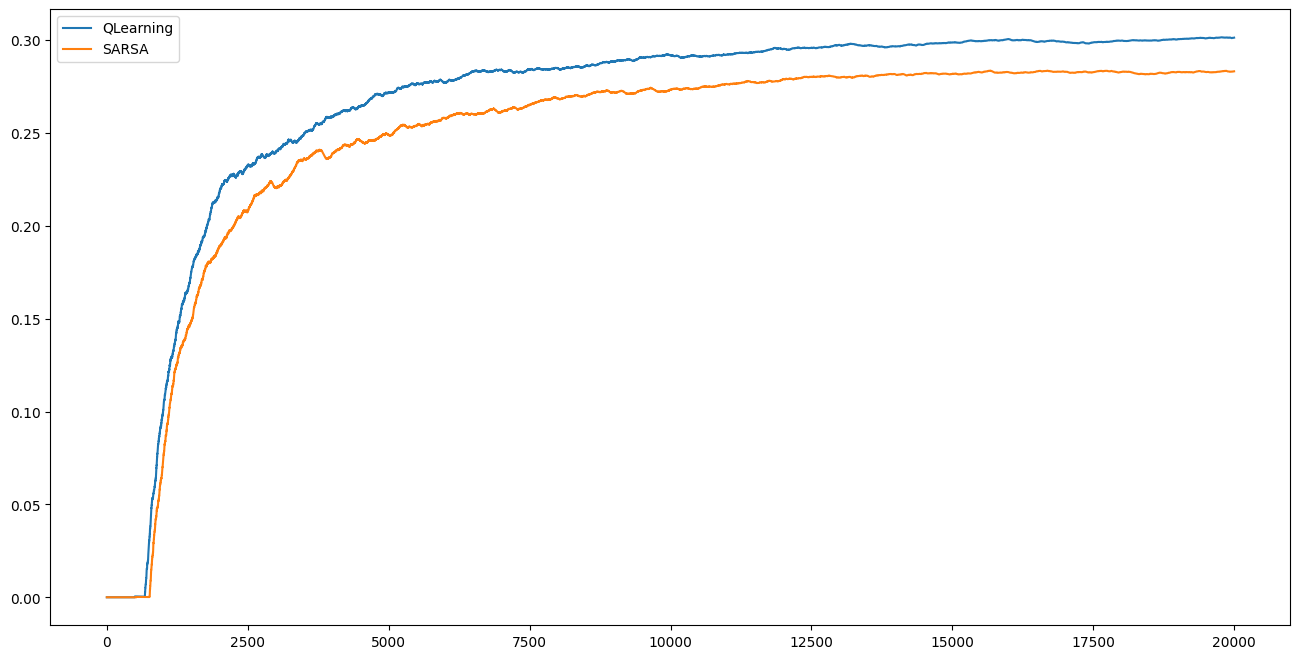

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.legend()
plt.show()

In [12]:
print('Q-learning')
plot_policy_arrows(agent_q.q_values, grid_size=4)
print('Sarsa')
plot_policy_arrows(agent_s.q_values, grid_size=4)

Q-learning
go straight go straight go straight turn right 
go straight go straight go straight go straight
go straight go straight go straight go straight
go straight go straight go straight Terminal
Sarsa
go straight go straight go straight go straight
go straight go straight go straight go straight
go straight go straight go straight go straight
go straight go straight go straight Terminal


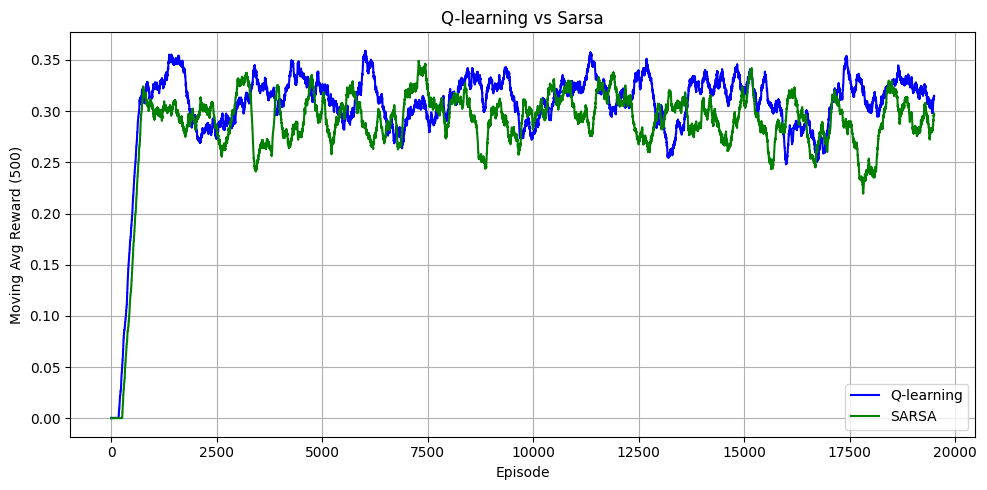

In [13]:
plot_rewards(rewards_q, rewards_s, window=500)

In [14]:
for qv in list(sorted(agent_q.q_values.items())):
    print(str(qv[1]))

[0.039653959237085284, 0.0412846901920609, 0.05621151655039765]
[0.04359360407375609, 0.042890368978009234, 0.051166298501167315]
[0.04798810001004263, 0.04772077274804314, 0.05413532189389355]
[0.04314112610151338, 0.04502329327234021, 0.04498354353574997]
[0.07292645115826472, 0.07109483020210859, 0.09656579214092385]
[0.106676585328916, 0.10644420579196882, 0.1361249105793113]
[0.10470784499969356, 0.10443482720641187, 0.1271081082830578]
[0.1176648404508891, 0.11944227857671175, 0.13123537041458966]
[0.09047345373336912, 0.08965031736022586, 0.12000372796237727]
[0.2221462903285692, 0.20994254285034644, 0.25117050324288953]
[0.24165023697064925, 0.24075698282122412, 0.2538219626509633]
[0.23942813135786742, 0.2404621556231765, 0.28404557920648577]
[0.10151851563424118, 0.09988855318402859, 0.15145847867739282]
[0.3325742587778928, 0.3323339438595384, 0.463275341647627]
[0.36150601337421734, 0.379828028850485, 0.6039896679843344]
[0.0, 0.0, 0.0]
